In [0]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize
from keras.callbacks import TensorBoard

import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize
from keras.datasets import cifar10

In [0]:
tensorboard = TensorBoard(
  log_dir='drive/My Drive/logs_updated',
  histogram_freq=0,
  batch_size=128,
  write_graph=True,
  write_grads=True
)

In [0]:
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	print(model.summary())
	return model

In [0]:
def define_generator(latent_dim):
	model = Sequential()
	
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	print(model.summary())
	return model

In [0]:
def define_gan(g_model, d_model):

	d_model.trainable = False

	model = Sequential()

	model.add(g_model)

	model.add(d_model)

	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	print(model.summary())
	return model

In [0]:
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

In [0]:
tensorboard.set_model(define_gan)

In [0]:
def load_real_samples():

	(trainX, _), (_, _) = load_data()

	X = trainX.astype('float32')

	X = (X - 127.5) / 127.5
	return X

In [0]:
def generate_real_samples(dataset, n_samples):

	ix = randint(0, dataset.shape[0], n_samples)

	X = dataset[ix]

	y = ones((n_samples, 1))
	return X, y

In [0]:
def generate_latent_points(latent_dim, n_samples):

	x_input = randn(latent_dim * n_samples)

	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [0]:
def generate_fake_samples(g_model, latent_dim, n_samples):

	x_input = generate_latent_points(latent_dim, n_samples)

	X = g_model.predict(x_input)

	y = zeros((n_samples, 1))
	return X, y

In [0]:
def save_plot(examples, epoch, n=8):

  examples = (examples+1)/2.0

  for i in range(n*n):
    pyplot.subplot(n,n,1+i)
    pyplot.axis('off')
    pyplot.imshow(examples[i])

  pyplot.savefig('drive/My Drive/saved_dcgan_grids_updated/generated_plote%05d.png' % (epoch+1))
  pyplot.close()

  # prepare the inception v3 model
  model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
  # load cifar10 images
  (_,_),(images1, _) = load_data()
  images2 = examples
  shuffle(images1)
  images1 = images1[:1000]
  print('Loaded', images1.shape, images2.shape)
  # convert integer to floating point values
  images1 = images1.astype('float32')
  images1 = (images1 - 127.5) / 127.5
  images2 = images2.astype('float32')
  # resize images
  images1 = scale_images(images1, (299,299,3))
  images2 = scale_images(images2, (299,299,3))
  print('Scaled', images1.shape, images2.shape)
  # pre-process images
  #images1 = preprocess_input(images1)
  #images2 = preprocess_input(images2)
  # calculate fid
  fid = calculate_fid(model, images1, images2)
  print('FID: %.3f' % fid)

In [0]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=1000):

	X_real, y_real = generate_real_samples(dataset, n_samples)

	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)

	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)

	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

	save_plot(x_fake, epoch)

	g_model.save('drive/My Drive/saved_dcgan_models_updated/generator_model_%05d.h5' % (epoch+1))

In [0]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
	
  for i in range(n_epochs):
    
	
    for j in range(bat_per_epo):
	
      X_real, y_real = generate_real_samples(dataset, half_batch)
	
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)
	
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
	
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)

      X_gan = generate_latent_points(latent_dim, n_batch)

      y_gan = ones((n_batch, 1))

      g_loss = gan_model.train_on_batch(X_gan, y_gan)

      
        
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
   
    tensorboard.on_epoch_end(n_epochs, {"D_real_loss":d_loss1 ,"D_fake_loss":d_loss2,"GAN_loss":g_loss})
      
	
    if (i+1) % 10 == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)


In [36]:
latent_dim = 100

d_model = define_discriminator()

g_model = define_generator(latent_dim)

gan_model = define_gan(g_model, d_model)

dataset = load_real_samples()

train(g_model, d_model, gan_model, dataset, latent_dim)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_946 (Conv2D)          (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_947 (Conv2D)          (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_948 (Conv2D)          (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_949 (Conv2D)          (None, 4, 4, 256)        

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


KeyboardInterrupt: ignored

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


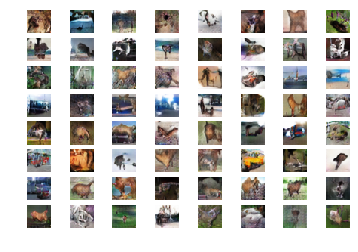

Loaded (1000, 32, 32, 3) (1000, 32, 32, 3)
Scaled (1000, 299, 299, 3) (1000, 299, 299, 3)
FID: 104.590


In [40]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot


# create and save a plot of generated images
def save_final_plot(examples, n):
	for i in range(n * n):
		pyplot.subplot(n, n, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(examples[i])
	pyplot.show()

model = load_model('drive/My Drive/saved_dcgan_models_updated/generator_model_00080.h5')
latent_points= generate_latent_points(100, 1000)
labels = asarray([x for _ in range(10) for x in range(10)])
X  = model.predict(latent_points)
X = (X + 1) / 2.0
save_final_plot(X, 8)

model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
# load cifar10 images
(_,_),(images1, _) = load_data()
images2 = X
shuffle(images1)
images1 = images1[:1000]
print('Loaded', images1.shape, images2.shape)
# convert integer to floating point values
images1 = images1.astype('float32')
images1 = (images1 - 127.5) / 127.5
images2 = images2.astype('float32')
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
#images1 = preprocess_input(images1)
#images2 = preprocess_input(images2)
# calculate fid
fid = calculate_fid(model, images1, images2)
print('FID: %.3f' % fid)

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
